In [1]:
# Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/codes.txt'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/images'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/labels'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

# Data

In [5]:
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/images/0001TP_006690.png'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/images/0001TP_006720.png'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/images/0001TP_006750.png'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/images/0001TP_006780.png'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/images/0001TP_006810.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:5]

[WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/labels/0001TP_006690_P.png'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/labels/0001TP_006720_P.png'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/labels/0001TP_006750_P.png'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/labels/0001TP_006780_P.png'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/camvid/labels/0001TP_006810_P.png')]

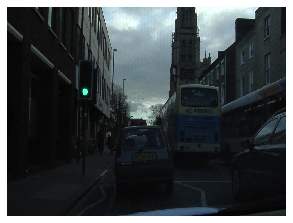

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

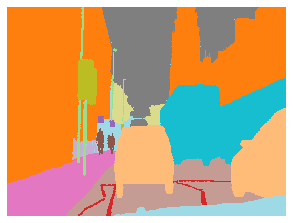

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
mask.shape

torch.Size([1, 720, 960])

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]),
 tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
len(codes)

32

# Dataset

In [14]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=2, have 4021MB of GPU RAM free


In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)#Same transformation on mask
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [17]:
size

array([360, 480], dtype=int32)

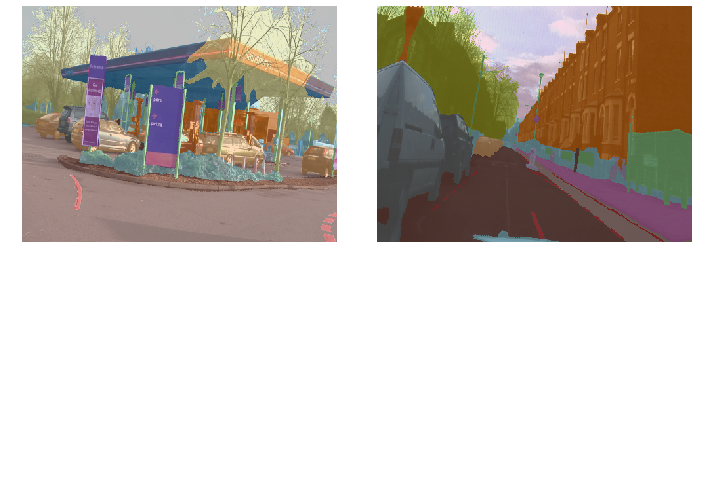

In [20]:
data.show_batch(2, figsize=(10,7))

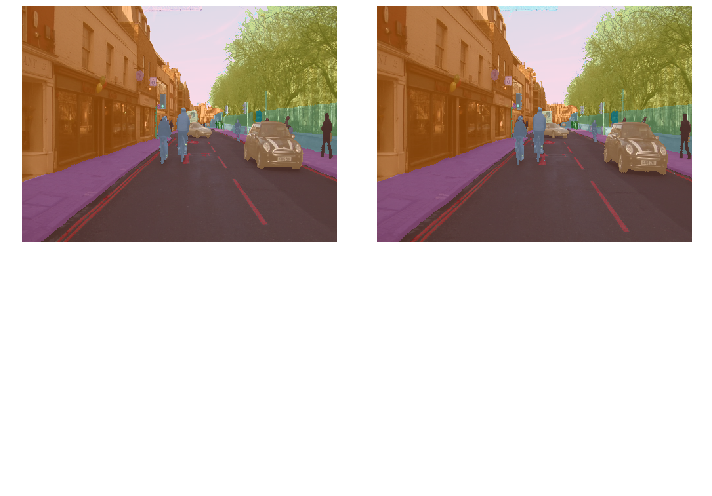

In [21]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# Model

In [22]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
print(void_code)

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

30


In [23]:
metrics=acc_camvid
# metrics=accuracy

In [24]:
wd=1e-2

In [25]:
learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd)

# Mixed Precision
Uncomment the line to convert floating point 16 instead of 32 bits.


learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd).to_fp16()

In [ ]:
# learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd).to_fp16())

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


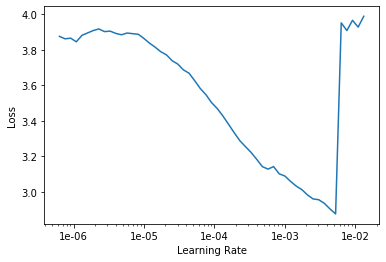

In [26]:
lr_find(learn)
learn.recorder.plot()

In [27]:
lr=3e-3

In [28]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.797673,0.646230,0.837860,04:41
1,0.712652,0.501655,0.863634,05:02
2,0.680431,0.531035,0.854551,04:57
3,0.665027,0.575756,0.857315,05:06
4,0.616365,0.506249,0.862178,05:20
5,0.612953,0.515364,0.854860,05:11
6,0.548664,0.469018,0.874203,04:53
7,0.574038,0.479059,0.872059,04:53
8,0.603800,0.543381,0.861156,04:53
9,0.470084,0.349660,0.900189,04:53


In [29]:
learn.save('stage-1')

In [30]:
learn.load('stage-1');

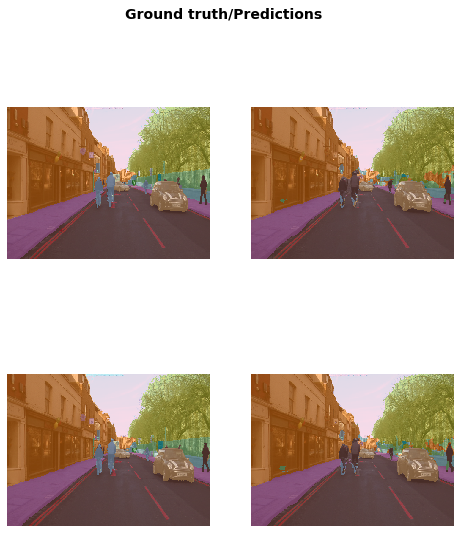

In [31]:
learn.show_results(rows=3, figsize=(8,9))

# Unfreeze and learn from scratch

In [32]:
learn.unfreeze()

In [33]:
lrs = slice(lr/400,lr/4)

In [34]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.425908,0.343769,0.901301,55:33
1,0.426448,0.344485,0.899324,04:51
2,0.410192,0.326046,0.906100,04:51
3,0.401291,0.346037,0.899343,05:03
4,0.406825,0.350978,0.897818,05:34
5,0.395229,0.324162,0.907093,05:21
6,0.370259,0.311761,0.909586,05:26
7,0.382684,0.302306,0.913156,05:32
8,0.385456,0.318547,0.913300,05:48
9,0.371435,0.347199,0.898386,05:52


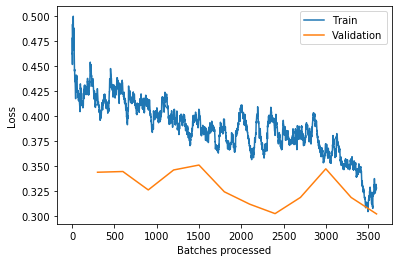

In [36]:
learn.recorder.plot_losses()

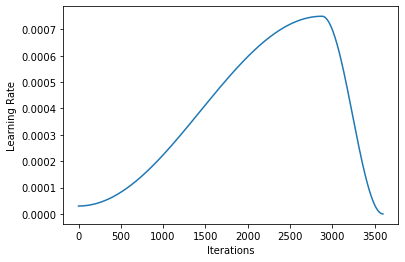

In [37]:
learn.recorder.plot_lr()

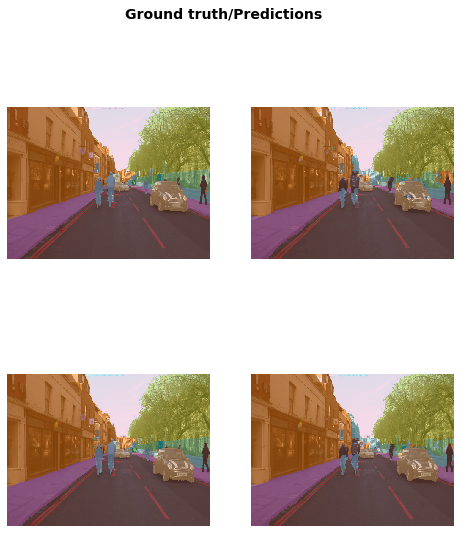

In [39]:
learn.show_results(rows=3, figsize=(8,9))

In [40]:
learn.save('stage-2');

# Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease bs.

In [48]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 3639MB of GPU RAM free


In [49]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [50]:
# learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd)
learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd).to_fp16()

In [51]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


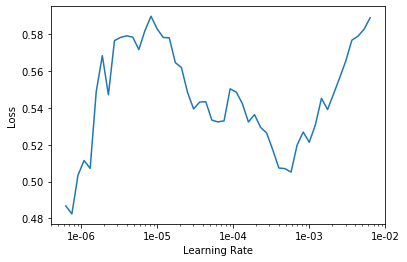

In [52]:
lr_find(learn)
learn.recorder.plot()

In [53]:
lr=1e-3

In [54]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.479260,0.395353,0.892778,2:32:13
1,0.428841,0.376958,0.895657,17:55
2,0.366892,0.398894,0.903291,15:54
3,0.415923,0.350332,0.903516,16:49
4,0.392305,0.394700,0.891803,17:35
5,0.393345,0.359075,0.907552,18:42
6,0.373949,0.400309,0.886952,19:07
7,0.360676,0.351927,0.897254,19:39
8,0.309240,0.316857,0.915672,20:34
9,0.264609,0.294245,0.918921,21:15


In [55]:
learn.save('stage-1-big')

In [56]:
learn.load('stage-1-big');

In [57]:
learn.unfreeze()

In [58]:
lrs = slice(1e-6,lr/10)

In [59]:
learn.fit_one_cycle(4, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.260939,0.281494,0.922384,25:26
1,0.259327,0.282790,0.920666,25:12
2,0.287922,0.280239,0.922150,23:35
3,0.242648,0.270233,0.925943,21:07


KeyboardInterrupt: 

In [60]:
learn.save('stage-2-big')

In [61]:
learn.load('stage-2-big');

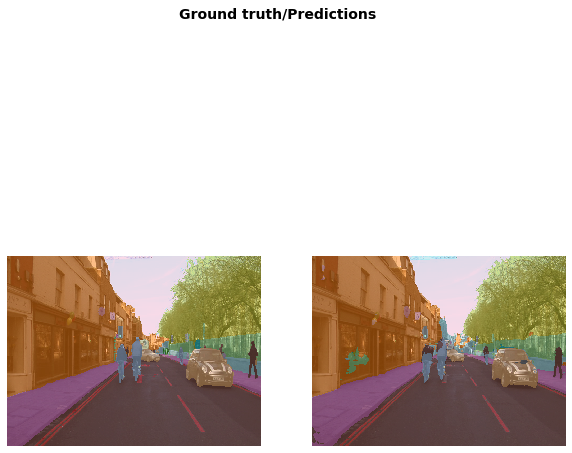

In [66]:
learn.show_results(rows=2, figsize=(10,10))